In [1]:
#Main imports
import sklearn as skl
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# MAGIC Gamma Telescope Data Set
* http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

### Attribute information:

1. **fLength**:  continuous  # major axis of ellipse [mm]
2. **fWidth**:   continuous  # minor axis of ellipse [mm] 
3. **fSize**:    continuous  # 10-log of sum of content of all pixels [in #phot]
4. **fConc**:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
5. **fConc1**:   continuous  # ratio of highest pixel over fSize  [ratio]
6. **fAsym**:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
7. **fM3Long**:  continuous  # 3rd root of third moment along major axis  [mm] 
8. **fM3Trans**: continuous  # 3rd root of third moment along minor axis  [mm]
9. **fAlpha**:   continuous  # angle of major axis with vector to origin [deg]
10. **fDist**:    continuous  # distance from origin to center of ellipse [mm]
11. **class**:    g,h         # gamma (signal), hadron (background)

Missing Attribute Values: *None*

Class Distribution:
* g = gamma (signal):     12332
* h = hadron (background): 6688

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

magic_raw = pd.read_csv("datasets/magic04.data", header=None)
magic_raw.columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
print("Contains nan? ", magic_raw.isnull().values.any())

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(magic_raw, magic_raw["class"]):
    magic = magic_raw.loc[train_index]
    magic_test = magic_raw.loc[test_index]

magic.describe()

Contains nan?  False


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,15216.000000,15216.000000,15216.000000,15216.000000,15216.000000,15216.000000,15216.000000,15216.000000,15216.000000,15216.000000
mean,53.162183,22.114864,2.823589,0.380522,0.214846,-4.194750,10.532512,0.392384,27.696525,193.511734
std,42.328375,18.251827,0.471254,0.182041,0.110241,59.228174,51.187792,20.721791,26.101137,74.774937
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.332975,11.858875,2.477100,0.237175,0.128900,-20.593350,-12.898750,-10.859375,5.578450,142.101225
50%,37.139200,17.130900,2.740000,0.355250,0.196750,4.225550,15.252900,1.279050,17.718250,191.451500
75%,69.934400,24.709350,3.098300,0.502925,0.285125,24.317775,35.782175,10.932400,45.932250,240.499950
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


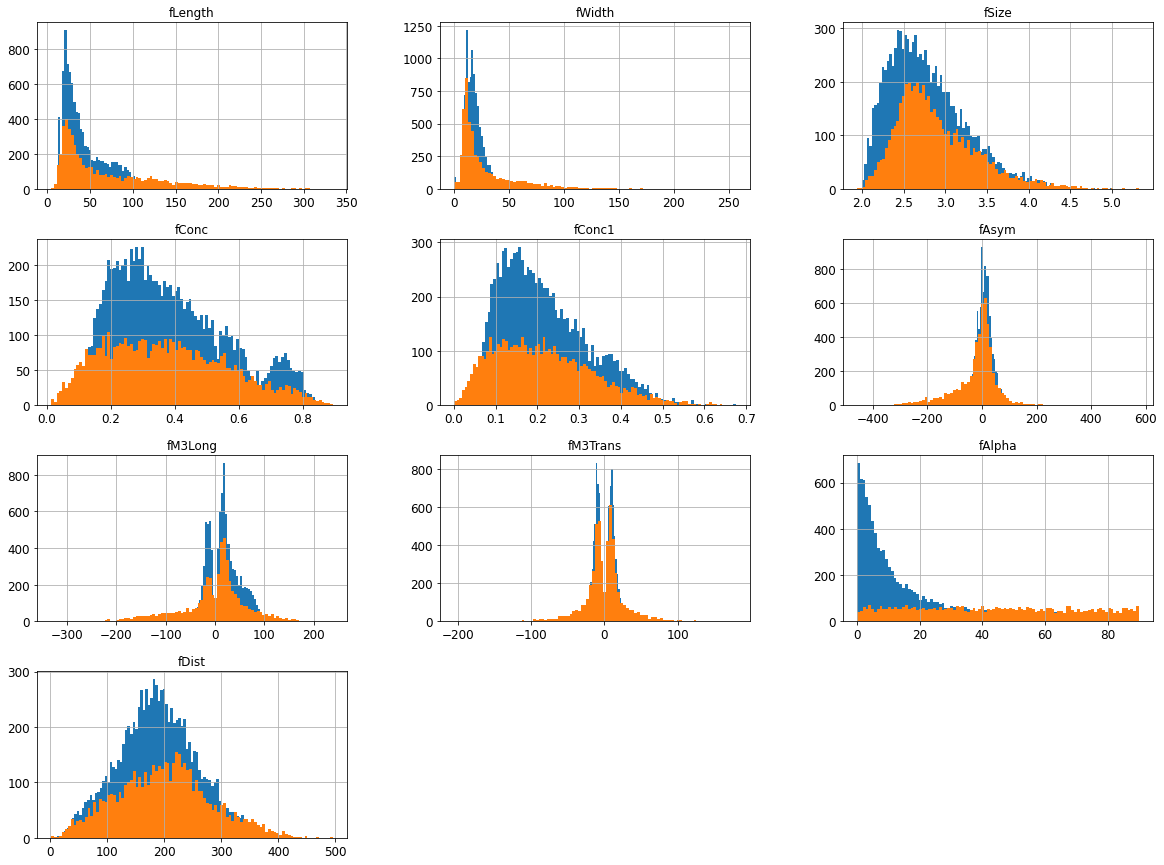

In [3]:
bins = 100
ax = magic[magic['class'] == 'g'].hist(bins=bins, figsize=(20,15));
magic[magic['class'] == 'h'].hist(bins=bins, ax = ax.reshape(1,12)[0][:10]);


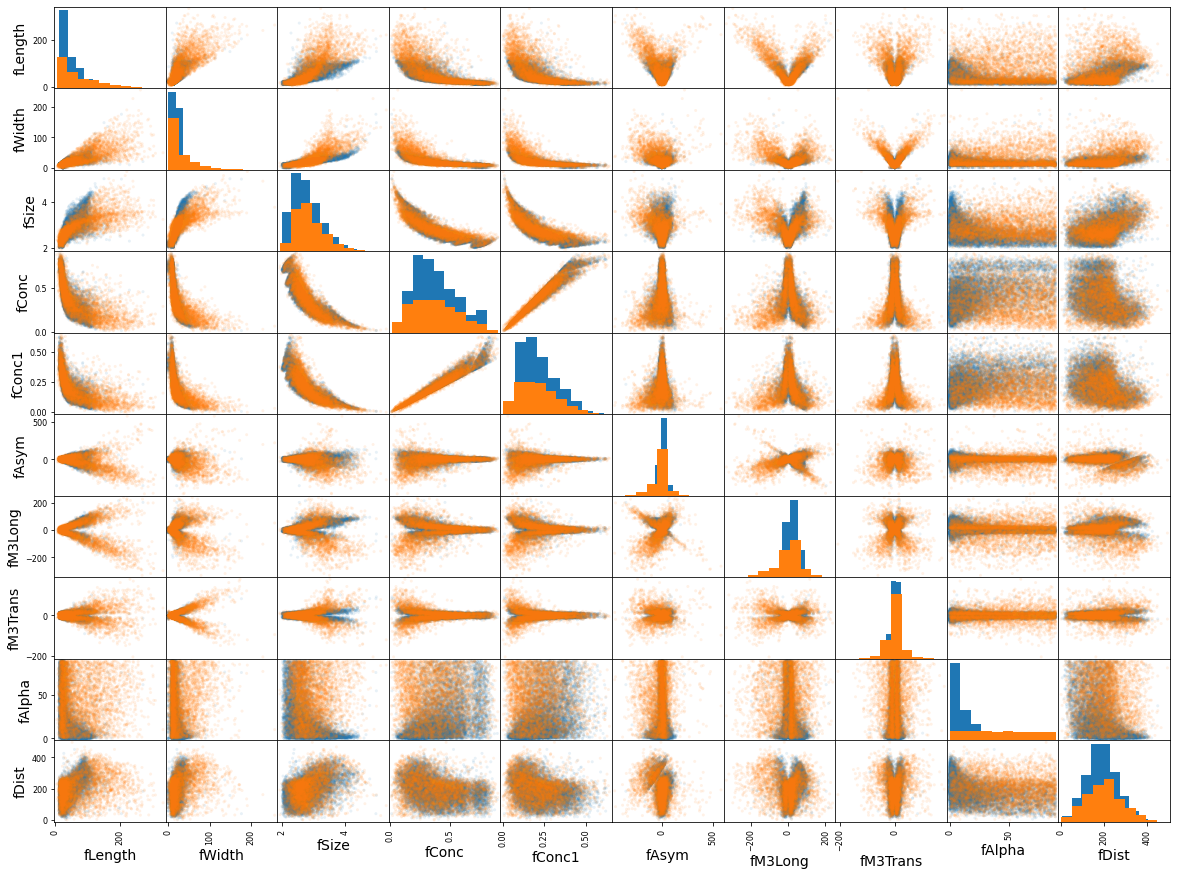

In [4]:
from pandas.plotting import scatter_matrix
attributes = magic.columns[:-1]
ax = scatter_matrix(magic[magic['class']=='g'][attributes], figsize=(20,15), alpha=0.1);
scatter_matrix(magic[magic['class']=='h'][attributes],ax=ax, alpha=0.1);

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

pipe = ColumnTransformer([
    ('encoder', OrdinalEncoder(), ['class']),
    ('std_scaler', StandardScaler(), attributes),
])

magic2 = pipe.fit_transform(magic)
X_train, y_train = magic2[:,1:],magic2[:,0]

magic2_test = pipe.fit_transform(magic_test)
X_test, y_test = magic2_test[:,1:],magic2_test[:,0]

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lin_clf = LinearDiscriminantAnalysis()
lin_clf.fit(X_train, y_train)

quad_clf = QuadraticDiscriminantAnalysis()
quad_clf.fit(X_train, y_train)

print("Linear: ", lin_clf.score(X_test, y_test))
print("Quadratic: ", quad_clf.score(X_test, y_test))

Linear:  0.7883806519453207
Quadratic:  0.7907465825446898


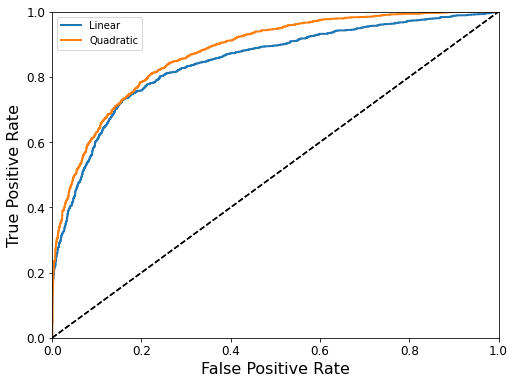

In [7]:
from sklearn.metrics import roc_curve

fpr_lin, tpr_lin, thresholds_lin = roc_curve(y_test, lin_clf.decision_function(X_test))
fpr_quad, tpr_quad, thresholds_quad = roc_curve(y_test, quad_clf.decision_function(X_test))

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lin, tpr_lin, "Linear")
plot_roc_curve(fpr_quad, tpr_quad, "Quadratic")
plt.legend()
plt.show()

# MiniBooNE particle identification Data Set
* http://archive.ics.uci.edu/ml/datasets/MiniBooNE+particle+identification

### Attribute information:
* The submitted file is set up as follows. In the first line is the the number of signal events followed by the number of background events. The signal (electron neutrino) events come first, followed by the background (muon neutrino) events. Each line, after the first line has the 50 particle ID variables for one event.


In [8]:
fname = "datasets/MiniBooNE_PID.txt"
with open(fname, 'r') as f:
    # print(f.readline().strip().split(" "))
    nsignal, nbackground = [int(x) for x in f.readline().strip().split(" ")]
    print(nsignal, nbackground)
    signal, background = np.zeros((nsignal,50),dtype=float), np.zeros((nbackground,50),dtype=float)
    for i, line in enumerate(f):
        if i < nsignal:
            signal[i]= [float(x) for x in line.strip().split()]
        else:
            background[i-nsignal]= [float(x) for x in line.strip().split()]

X_train = np.r_[signal[:int(nsignal*.8),:], background[:int(nbackground*.8),:]]
X_test = np.r_[signal[int(nsignal*.8):,:], background[int(nbackground*.8):,:]]
# y_train = np.c_[np.ones((1,int(nsignal*.8))), np.zeros((1,int(nbackground*.8)))]
y_train = np.r_[np.ones(int(nsignal*.8)), np.zeros(int(nbackground*.8))]
y_test = np.r_[np.ones(nsignal-int(nsignal*.8)), np.zeros(nbackground-int(nbackground*.8))]


36499 93565


In [9]:
boone = pd.DataFrame(np.c_[y_train,X_train])
boone = boone.replace(-999, boone.median())

# for col in boone.columns:
#     boone[col] = boone[col].replace(-999, boone[col].median())
boone.describe()


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,...,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000,104051.000000
mean,0.280622,4.863246,1.492421,127.945994,0.283172,0.009298,0.160437,0.969730,0.824028,3.451148,...,145.285703,-21.771998,0.730642,6.005181,0.009035,0.178721,-0.158323,2.859428,1.611956,0.230681
std,0.449305,1.157430,0.857819,183.864957,0.059465,0.012483,0.122631,0.342224,0.070301,0.258538,...,31.676536,33.774968,1.213658,4.563961,0.029577,0.080344,0.977490,1.914645,1.958498,0.052798
min,0.000000,0.000000,0.059691,0.012381,0.104697,-0.156118,0.000000,0.000000,0.033510,2.375270,...,33.895200,-387.617000,-1.686500,0.249186,0.000000,0.000000,-27.548400,-13.492200,-15.997800,0.000000
25%,0.000000,4.026930,0.884759,50.332650,0.242092,0.001238,0.086597,0.718584,0.784416,3.286610,...,123.284000,-39.771400,-0.019187,3.431280,0.000000,0.122504,-0.334119,1.433990,0.284733,0.197798
50%,0.000000,4.786840,1.383410,106.163000,0.272138,0.004975,0.141031,0.922918,0.834038,3.426500,...,145.412000,-21.647400,0.458053,4.763610,0.000000,0.168480,0.043297,2.367150,1.125950,0.231367
75%,1.000000,5.628570,1.947480,138.974000,0.315367,0.013119,0.212018,1.179545,0.874216,3.585955,...,167.122000,-3.380575,1.149280,6.853875,0.001973,0.224867,0.295539,3.775875,2.281855,0.263304
max,1.000000,16.599000,8.802820,4747.670000,0.736804,0.179012,0.703859,6.241080,0.989713,7.170170,...,331.925000,161.298000,43.651200,85.823100,0.446914,0.605667,1.932890,21.768200,25.423300,0.625484


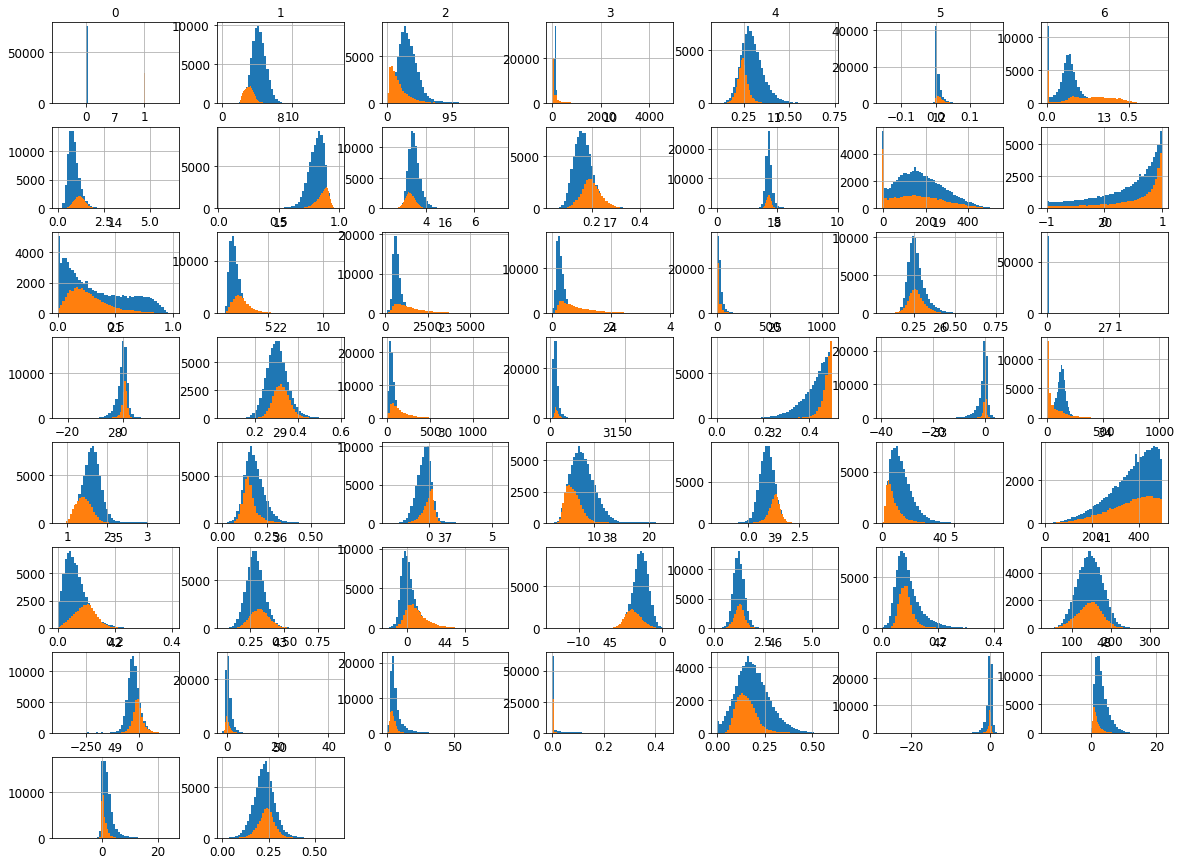

In [10]:
bins = 50
ax = boone[boone[0] == 0].hist(bins=bins, figsize=(20,15));
boone[boone[0] == 1].hist(bins=bins, ax = ax.flatten()[:51]);
#Looks mostly like detected PID mass distributions

In [11]:
lin_clf = LinearDiscriminantAnalysis()
lin_clf.fit(X_train, y_train)

quad_clf = QuadraticDiscriminantAnalysis()
quad_clf.fit(X_train, y_train)

print("Linear: ", lin_clf.score(X_test, y_test))
print("Quadratic: ", quad_clf.score(X_test, y_test))

Linear:  0.904047976011994
Quadratic:  0.7156037365932418


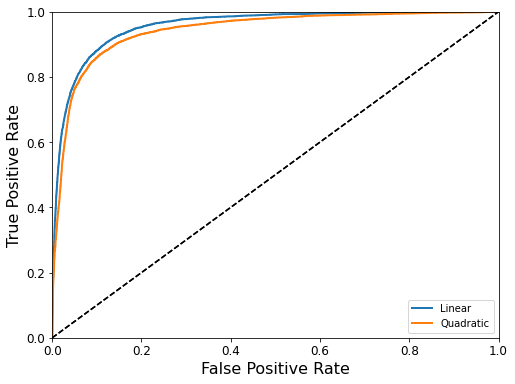

In [12]:
fpr_lin, tpr_lin, thresholds_lin = roc_curve(y_test, lin_clf.decision_function(X_test))
fpr_quad, tpr_quad, thresholds_quad = roc_curve(y_test, quad_clf.decision_function(X_test))

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lin, tpr_lin, "Linear")
plot_roc_curve(fpr_quad, tpr_quad, "Quadratic")
plt.legend()
plt.show()

# Volcanoes on Venus - JARtool experiment Data Set
* http://archive.ics.uci.edu/ml/datasets/Volcanoes+on+Venus+-+JARtool+experiment

### Attribute information:

Maybe a regression and classification problem? I'm going to try to classify number of volcanoes in an image-- I don't think it's going to work very well -> test gave me a score of 0 haha


fig, axs = plt.subplots(4,4, figsize=(20,15))
for i in range(4):
    for j in range(4):
        A = np.fromfile('datasets/volcanoes/Images/img'+str(i*4+j+1)+'.sdt', dtype='int8', sep="")
        A = A.reshape([1024, 1024])
        axs[i,j].imshow(A)

img_files = []
for file in os.listdir("datasets/volcanoes/Images/"):
    if file.endswith(".sdt"):
        img_files.append("datasets/volcanoes/Images/"+file)

label_files = [] #['']*len(img_files)
for file in os.listdir("datasets/volcanoes/GroundTruths/"):
    if file.endswith(".lxyr"):
        label_files.append("datasets/volcanoes/GroundTruths/"+file)

img_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
label_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

y = np.array([0]*len(img_files),dtype=int)
for i, ff in enumerate(label_files):
    with open(ff, 'r') as f:
        y[i]=len(f.readlines())

X = np.zeros((len(img_files), 1024*1024), dtype=float)
for i, ff in enumerate(img_files):
    X[i]=np.fromfile(ff, dtype='int8', sep="")/127

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

lin_clf = LinearDiscriminantAnalysis()
quad_clf = QuadraticDiscriminantAnalysis()
lin_scores, quad_scores = [], []

for idx_train, idx_test in loo.split(X):
    X_train, X_test = X[idx_train], X[idx_test]
    y_train, y_test = y[idx_train], y[idx_test]

    lin_clf.fit(X_train, y_train)
    ls = lin_clf.score(X_test, y_test)
    lin_scores.append(ls)
    print("\rLin: ", ls, end="")

    quad_clf.fit(X_train, y_train)
    qs = quad_clf.score(X_test, y_test)
    quad_scores.append(qs)
    print("\rQuad: ", ls, end="")




print("Linear: ", np.mean(lin_scores), np.std(lin_scores))
print("Quadratic: ", np.mean(quad_scores), np.std(quad_scores))

# Congressional Voting Records Data Set
* http://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records

### Attribute information:

1. **Class Name**: 2 (democrat, republican)
2. **handicapped-infants**: 2 (y,n)
3. **water-project-cost-sharing**: 2 (y,n)
4. **adoption-of-the-budget-resolution**: 2 (y,n)
5. **physician-fee-freeze**: 2 (y,n)
6. **el-salvador-aid**: 2 (y,n)
7. **religious-groups-in-schools**: 2 (y,n)
8. **anti-satellite-test-ban**: 2 (y,n)
9. **aid-to-nicaraguan-contras**: 2 (y,n)
10. **mx-missile**: 2 (y,n)
11. **immigration**: 2 (y,n)
12. **synfuels-corporation-cutback**: 2 (y,n)
13. **education-spending**: 2 (y,n)
14. **superfund-right-to-sue**: 2 (y,n)
15. **crime**: 2 (y,n)
16. **duty-free-exports**: 2 (y,n)
17. **export-administration-act-south-africa**: 2 (y,n)

### Missing Attribute Values: 
* Denoted by **?**

In [13]:
votes = pd.read_csv('datasets/house-votes-84.data', header=None)

enc = OrdinalEncoder()
votes = enc.fit_transform(votes)
print(enc.categories_)
votes = pd.DataFrame(votes)
# votes = votes.replace(0, np.nan)
# votes = votes.fillna(votes.mode)

votes.columns = ["Class","handicapped","water","budget","physician","el-salvador",\
    "religious","satellite","nicaraguan","missile","immigration", "cutback","education",\
    "sue","crime","duty-free","export"]
votes.describe()

[array(['democrat', 'republican'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object), array(['?', 'n', 'y'], dtype=object)]


,Class,handicapped,water,budget,physician,el-salvador,religious,satellite,nicaraguan,missile,immigration,cutback,education,sue,crime,duty-free,export
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.00000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,0.386207,1.402299,1.337931,1.556322,1.381609,1.452874,1.60000,1.517241,1.521839,1.425287,1.480460,1.296552,1.321839,1.422989,1.531034,1.335632,1.379310
std,0.487440,0.544342,0.667418,0.545974,0.535928,0.563449,0.53967,0.561065,0.564998,0.588527,0.531462,0.553049,0.601347,0.599866,0.572671,0.593742,0.845718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.00000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
75%,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


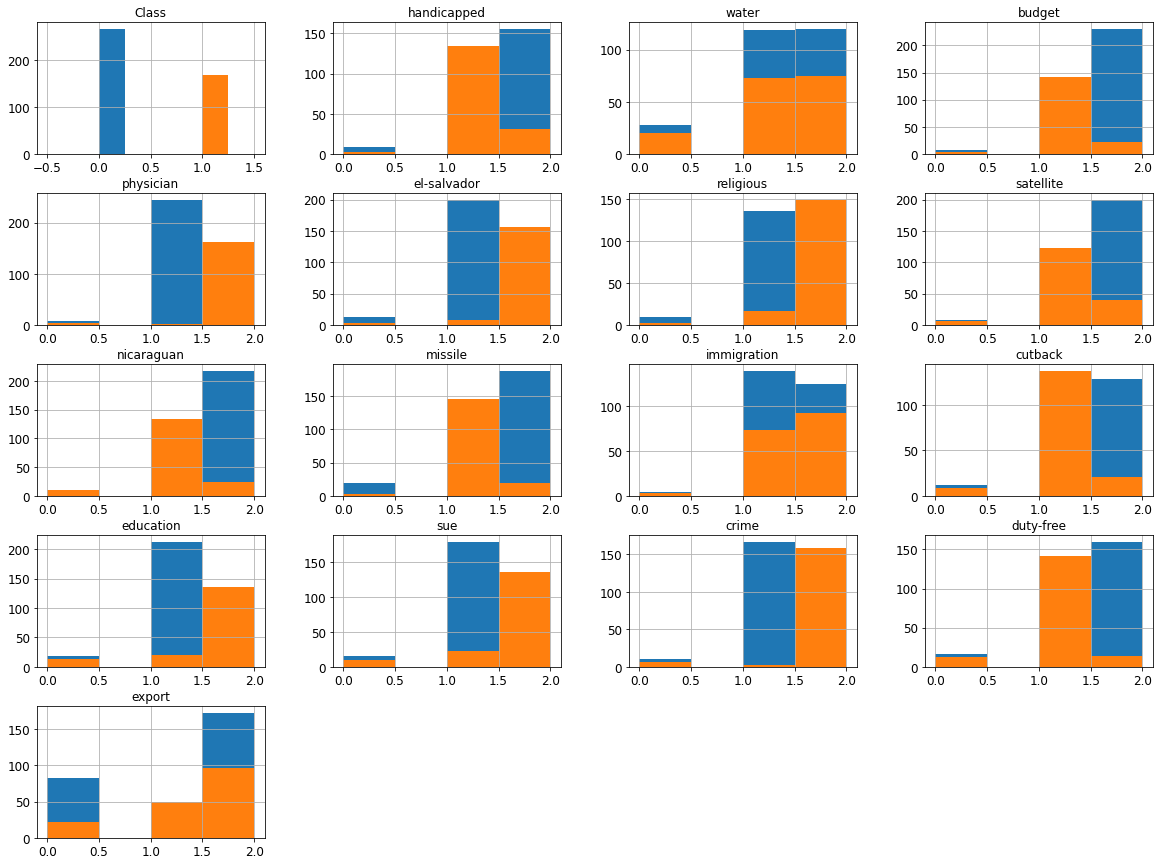

In [14]:
bins = 4
ax = votes[votes['Class'] == 0].hist(bins=bins, figsize=(20,15));
votes[votes['Class'] == 1].hist(bins=bins, ax = ax.flatten()[:17]);
#Looks mostly like detected PID mass distributions

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(votes, votes["Class"]):
    votes_train = votes.loc[train_index].to_numpy()
    votes_test = votes.loc[test_index].to_numpy()

y_train = votes_train[:,0]
X_train = votes_train[:,1:]

y_test = votes_test[:,0]
X_test = votes_test[:,1:]

Linear:  0.9655172413793104
Quadratic:  0.9540229885057471


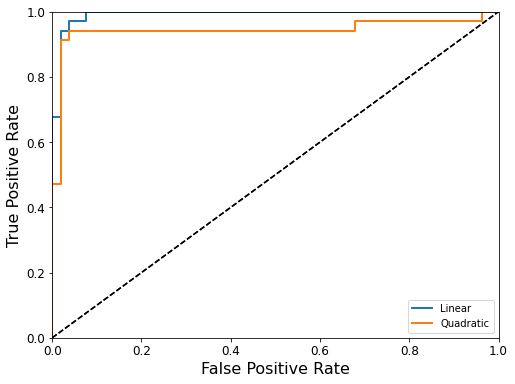

In [16]:
lin_clf = LinearDiscriminantAnalysis()
lin_clf.fit(X_train, y_train)

quad_clf = QuadraticDiscriminantAnalysis()
quad_clf.fit(X_train, y_train)

print("Linear: ", lin_clf.score(X_test, y_test))
print("Quadratic: ", quad_clf.score(X_test, y_test)) #I guess figuring out repub or demo is really easy if you look at what people vote for

fpr_lin, tpr_lin, thresholds_lin = roc_curve(y_test, lin_clf.decision_function(X_test))
fpr_quad, tpr_quad, thresholds_quad = roc_curve(y_test, quad_clf.decision_function(X_test))

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lin, tpr_lin, "Linear")
plot_roc_curve(fpr_quad, tpr_quad, "Quadratic")
plt.legend()
plt.show()

# Statlog (Landsat Satellite)
* https://archive-beta.ics.uci.edu/ml/datasets/146

### Attribute information:


In [17]:
train = pd.read_csv('datasets/sat.trn', delimiter=' ', header=None)
test = pd.read_csv('datasets/sat.tst', delimiter=' ', header=None)
train.describe()


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
count,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,...,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000
mean,69.473957,83.855242,99.322886,82.555581,69.208794,83.499436,99.174521,82.480496,68.963472,83.131003,...,82.673957,69.033145,83.434273,99.183766,82.638106,68.797069,83.153326,99.061556,82.584442,3.650282
std,13.649635,22.725079,16.672166,18.695450,13.552423,22.811809,16.627583,18.714272,13.497858,22.813312,...,18.884322,13.533934,22.812090,16.741240,18.939820,13.437785,22.762684,16.660735,18.895513,2.217055
min,40.000000,27.000000,56.000000,33.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,...,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000,1.000000
25%,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,...,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,69.000000,2.000000
50%,68.000000,87.000000,101.000000,83.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,...,81.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,100.000000,81.000000,3.000000
75%,80.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,...,92.000000,79.500000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,5.000000
max,104.000000,137.000000,140.000000,154.000000,102.000000,137.000000,145.000000,157.000000,104.000000,130.000000,...,154.000000,104.000000,128.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000,7.000000


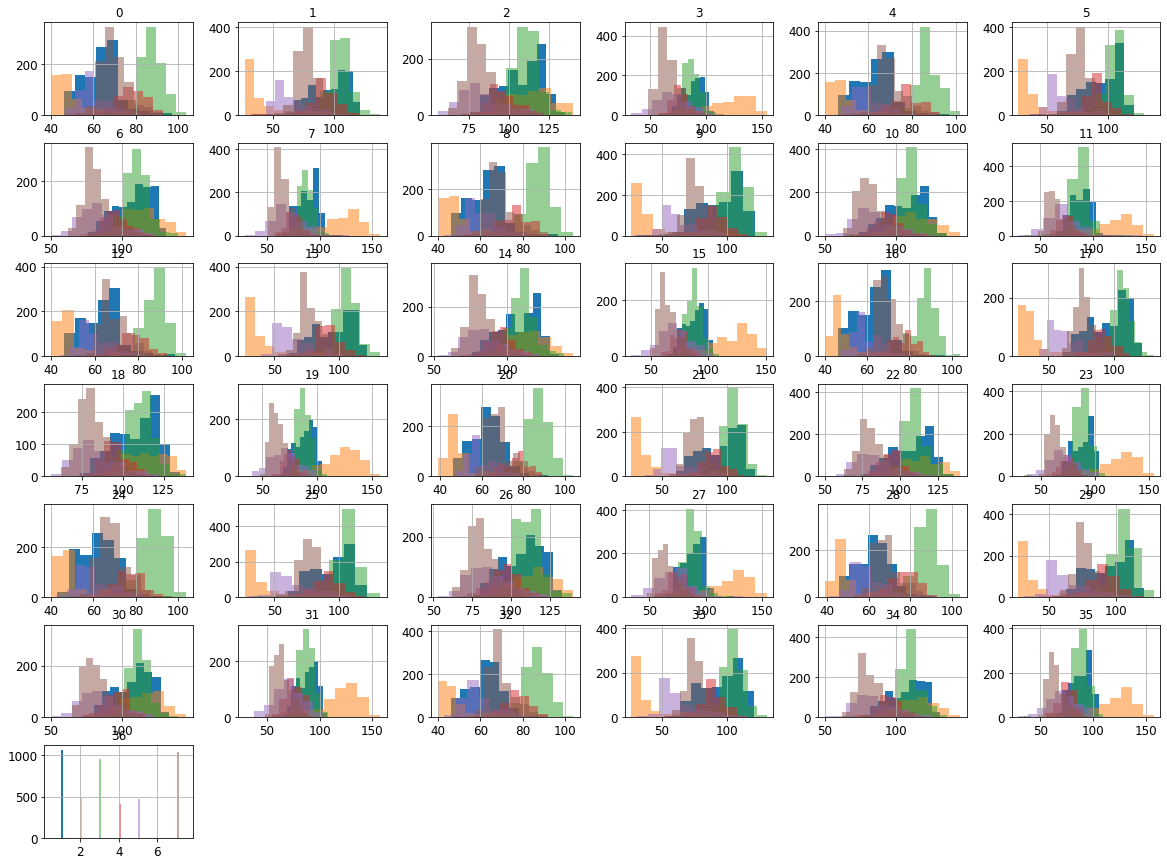

In [18]:
bins = 10
ax = train[train[36] == 1].hist(bins=bins, figsize=(20,15));
train[train[36] == 2].hist(bins=bins, ax = ax.flatten()[:37], alpha=.5);
train[train[36] == 3].hist(bins=bins, ax = ax.flatten()[:37], alpha=.5);
train[train[36] == 4].hist(bins=bins, ax = ax.flatten()[:37], alpha=.5);
train[train[36] == 5].hist(bins=bins, ax = ax.flatten()[:37], alpha=.5);
train[train[36] == 7].hist(bins=bins, ax = ax.flatten()[:37], alpha=.5);


In [19]:
from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse=False)
enc = OrdinalEncoder()
y_train = train.to_numpy()[:,36]
X_train = train.to_numpy()[:,:36]

y_test = test.to_numpy()[:,36]
X_test = test.to_numpy()[:,:36]

y_train = enc.fit_transform(y_train.reshape(-1,1)).flatten()
y_test = enc.transform(y_test.reshape(-1,1)).flatten()
# y_train = ohe.fit_transform(y_train.reshape(-1,1))
# y_test = ohe.transform(y_test.reshape(-1,1))
y_train

array([2., 2., 2., ..., 3., 3., 3.])

In [20]:
lin_clf = LinearDiscriminantAnalysis()
lin_clf.fit(X_train, y_train)

quad_clf = QuadraticDiscriminantAnalysis()
quad_clf.fit(X_train, y_train)

print("Linear: ", lin_clf.score(X_test, y_test))
print("Quadratic: ", quad_clf.score(X_test, y_test))

# fpr_lin, tpr_lin, thresholds_lin = roc_curve(y_test, lin_clf.decision_function(X_test))
# fpr_quad, tpr_quad, thresholds_quad = roc_curve(y_test, quad_clf.decision_function(X_test))

# plt.figure(figsize=(8, 6))
# plot_roc_curve(fpr_lin, tpr_lin, "Linear")
# plot_roc_curve(fpr_quad, tpr_quad, "Quadratic")
# plt.legend()
# plt.show()

Linear:  0.8285
Quadratic:  0.848
